In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import glob
import numpy as np
import xgboost as xgb


In [2]:
cornbelters_files = glob.glob("../KCLData/*.csv")
other_files = glob.glob("../CornBeltersData/*.csv")

all_files = cornbelters_files + other_files

# Read and concatenate all CSVs into one DataFrame
stuff_plus = [pd.read_csv(f) for f in all_files]
df = pd.concat(stuff_plus, ignore_index=True)


In [3]:
dft = df[['TaggedPitchType','Pitcher','PlayResult','RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak','VertApprAngle','ZoneSpeed']]

# Create dummy variables for TaggedPitchType
dummies = pd.get_dummies(dft['TaggedPitchType'], prefix='PitchType',dtype=float)
dft = pd.concat([dft, dummies], axis=1)
pitch_type_dummies = [col for col in dft.columns if col.startswith('PitchType_')]

In [4]:
dft['PlayResult'].unique()


array([nan, 'StrikeoutLooking', 'StrikeoutSwinging', 'Out', 'Single',
       'Walk', 'Error', 'Double', 'Triple', 'HomeRun', 'FieldersChoice',
       'Sacrifice', 'HItByPitch'], dtype=object)

In [5]:
dft = dft.dropna()

In [6]:
map_data = {
    'Out': -.33,
    'Single': .46,
    'Double': .79,
    'StrikeoutLooking': -.33,
    'StrikeoutSwinging': -.33,
    'Error': 0,
    'Walk': .31,
    'Triple': 1.07,
    'HomeRun': 1.41,
    'FieldersChoice': 0,
    'Sacrifice': 0,
    'HItByPitch': .33  # Fixed typo: was 'HItByPitch': .330
}

dft['PlayResult'] = dft['PlayResult'].map(map_data)

In [7]:
# Create a mapping from value to label
value_to_label = {v: k for k, v in map_data.items()}

# Count frequencies
outcome_counts = dft['PlayResult'].value_counts().sort_index()

# Build the table as a DataFrame
table = pd.DataFrame({
    'Mapped Value': outcome_counts.index,
    'Label': [value_to_label.get(round(val, 2), "") for val in outcome_counts.index],
    'Frequency': outcome_counts.values
})

print(table)

   Mapped Value              Label  Frequency
0         -0.33  StrikeoutSwinging       1816
1          0.00          Sacrifice        141
2          0.31               Walk        352
3          0.33         HItByPitch          1
4          0.46             Single        579
5          0.79             Double        137
6          1.07             Triple         23
7          1.41            HomeRun         30


In [8]:
outcome_counts = df['PlayResult'].value_counts().sort_index()

mapped_values = [map_data.get(label, np.nan) for label in outcome_counts.index]
total = outcome_counts.values.sum()

table = pd.DataFrame({
    'Outcome': outcome_counts.index,
    'Mapped Value': mapped_values,
    'Frequency': outcome_counts.values,
    'Percentage' : outcome_counts.values /  total
})

print(table)

              Outcome  Mapped Value  Frequency  Percentage
0              Double          0.79        152    0.043491
1               Error          0.00         96    0.027468
2      FieldersChoice          0.00         40    0.011445
3          HItByPitch          0.33          1    0.000286
4             HomeRun          1.41         34    0.009728
5                 Out         -0.33       1375    0.393419
6           Sacrifice          0.00         22    0.006295
7              Single          0.46        657    0.187983
8    StrikeoutLooking         -0.33        225    0.064378
9   StrikeoutSwinging         -0.33        458    0.131044
10             Triple          1.07         24    0.006867
11               Walk          0.31        411    0.117597


In [9]:
offspeed_pitches = ['Sinker','Curveball','Slider','Cutter','Cutter']

def calculate_ff_diff(event):
    """Calculate fastball speed difference with error handling"""
    if pd.notna(event['RelSpeed']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = df[(df['Pitcher'] == event['Pitcher']) & 
                         (df['TaggedPitchType'] == 'Fastball')]['RelSpeed'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['RelSpeed']
    return np.nan

def calculate_ivb_diff(event):
    """Calculate induced vertical break difference with error handling"""
    if pd.notna(event['InducedVertBreak']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = df[(df['Pitcher'] == event['Pitcher']) & 
                         (df['TaggedPitchType'] == 'Fastball')]['InducedVertBreak'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['InducedVertBreak']
    return np.nan

def calculate_hb_diff(event):
    """Calculate horizontal break difference with error handling"""
    if pd.notna(event['HorzBreak']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = df[(df['Pitcher'] == event['Pitcher']) & 
                         (df['TaggedPitchType'] == 'Fastball')]['HorzBreak'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['HorzBreak']
    return np.nan

In [10]:
dft['ff_diff'] = dft.apply(calculate_ff_diff, axis=1)
dft['ivb_diff'] = dft.apply(calculate_ivb_diff, axis=1)
dft['hb_diff'] = dft.apply(calculate_hb_diff, axis=1)
    

In [11]:
dft.head()

TaggedPitchType       Pitcher  PlayResult   RelSpeed     SpinRate  \
6           Slider   Roy Rolston       -0.33  78.997127  2234.354700   
12        Fastball   Roy Rolston       -0.33  86.577867  2090.806727   
16        Fastball   Roy Rolston       -0.33  87.530392  1987.298234   
20          Slider  Devan Tupper       -0.33  80.916924  2165.574886   
28        Fastball  Devan Tupper       -0.33  85.023046  1722.172115   

    RelHeight   RelSide  Extension  InducedVertBreak  HorzBreak  ...  \
6    5.643353  1.872089        6.0          6.484273  -2.228677  ...   
12   5.238482  2.212006        6.0         17.096434  15.031649  ...   
16   5.566592  2.257963        6.0         18.543534  12.824408  ...   
20   5.271006  2.011555        6.0         -1.006549   4.595121  ...   
28   5.837093  2.935782        6.0         14.298228  13.349795  ...   

    PitchType_Curveball  PitchType_Cutter  PitchType_Fastball  \
6                   0.0               0.0                 0.0   
12                  0.0               0.0                 1.0   
16                  0.0               0.0                 1.0   
20                  0.0               0.0                 0.0   
28                  0.0               0.0                 1.0   

    PitchType_Knuckleball  PitchType_Sinker  PitchType_Slider  \
6                     0.0               0.0               1.0   
12                    0.0               0.0               0.0   
16                    0.0               0.0               0.0   
20                    0.0               0.0               1.0   
28                    0.0               0.0               0.0   

    PitchType_Splitter   ff_diff   ivb_diff    hb_diff  
6                  0.0  6.567863  11.272762  14.542166  
12                 0.0       NaN        NaN        NaN  
16                 0.0       NaN        NaN        NaN  
20                 0.0  4.389381  15.222346   8.922750  
28                 0.0       NaN        NaN        NaN  

[5 rows x 23 columns]

In [12]:
features = ['RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak','VertApprAngle','ZoneSpeed','ff_diff','ivb_diff','hb_diff'] + pitch_type_dummies

In [13]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.model_selection import RandomizedSearchCV, KFold,train_test_split
from scipy.stats import uniform, randint
from xgboost import XGBRegressor
from sklearn.datasets import make_regression
import numpy as np
from math import sqrt


X = dft[features]
y = dft['PlayResult']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Define the pipeline with RobustScaler and XGBRegressor
pipeline = make_pipeline(
    RobustScaler(),
    XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42, scale_pos_weight=3.5)
)

param_distributions = {
    'xgbregressor__n_estimators': randint(3000, 7000),
    'xgbregressor__learning_rate': uniform(0.01, 0.15),
    'xgbregressor__max_depth': randint(12, 18),
    'xgbregressor__min_child_weight': randint(1, 10),
    'xgbregressor__subsample': uniform(0.9, 0.1),
    'xgbregressor__colsample_bytree': uniform(0.9, 0.1),
    'xgbregressor__colsample_bylevel': uniform(0.9, 0.1),
    'xgbregressor__colsample_bynode': uniform(0.9, 0.1),
    'xgbregressor__gamma': uniform(0, 0.1),
    'xgbregressor__reg_alpha': uniform(0, 0.03),
    'xgbregressor__reg_lambda': uniform(0, 0.05),
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=500,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

print("\nStarting RandomizedSearchCV...")
pt = PowerTransformer(method='yeo-johnson')
y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1))
y_test_transformed = pt.transform(y_test.values.reshape(-1, 1))
random_search.fit(X_train, y_train_transformed.ravel())
y_pred_transformed = random_search.predict(X_test)
y_pred = pt.inverse_transform(y_pred_transformed.reshape(-1, 1))

print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation RMSE: {sqrt(-random_search.best_score_)}")



Starting RandomizedSearchCV...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [84]:
xgb_model = random_search.best_estimator_



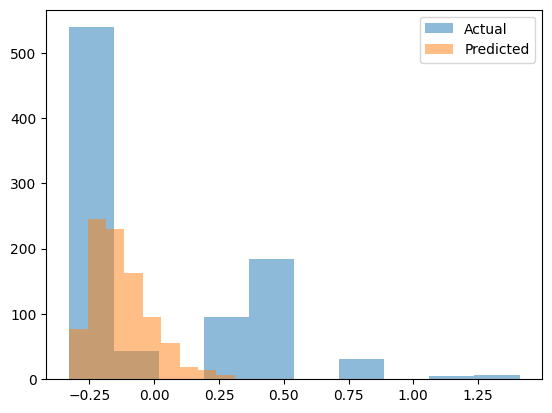

In [92]:
import matplotlib.pyplot as plt
plt.hist(y_test, alpha=0.5, label='Actual')
plt.hist(y_pred, alpha=0.5, label='Predicted')
plt.legend()
plt.show()

In [86]:
y_train.mean()

np.float64(-0.013216229589312237)

In [88]:
stats_df = pd.DataFrame({'y_test' : y_test, 'y_pred':y_pred })

In [89]:
stats_df.to_csv('stats.csv')

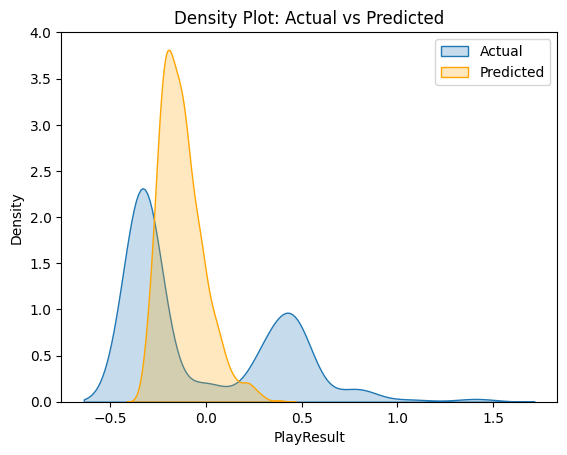

In [95]:
sns.kdeplot(y_test, label='Actual', fill=True)
sns.kdeplot(y_pred.ravel(), label='Predicted', fill=True, color='orange')
plt.xlabel('PlayResult')
plt.ylabel('Density')
plt.title('Density Plot: Actual vs Predicted')
plt.legend()
plt.show()

In [14]:
y.mean()

np.float64(-0.014461385482267166)

In [15]:
y.median()

np.float64(-0.33)

In [120]:
import numpy as np
import pandas as pd

def predict_stuff_plus(event):
    # Define the full set of features used in training (12 features, based on error expecting 12)
    required_features = ['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 
                        'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'ZoneSpeed', 
                        'ff_diff', 'ivb_diff', 'hb_diff']
    
    # Check if all required features are present; fill missing with 0 for fastballs
    input_data = {}
    for f in required_features:
        if f in event and not pd.isna(event[f]):
            input_data[f] = event[f]
        else:
            # For fastballs, set diff features to 0 if missing
            if event['TaggedPitchType'] == 'Fastball' and f in ['ff_diff', 'ivb_diff', 'hb_diff']:
                input_data[f] = 0
            else:
                return np.nan  # Missing critical feature
    
    # Convert to DataFrame for pipeline compatibility
    input_df = pd.DataFrame([input_data], columns=required_features)
    
    # Predict using the trained model (pipeline handles scaling)
    pred = xgb_model.predict(input_df)[0]
    
    # Apply inverse sigmoid transformation to compress to (0, 1), where higher pred -> lower Stuff+
    k = 50  # Steepness parameter (adjusted for xRV range)
    xrv_mean = y.mean() if hasattr(y, 'mean') else 0.28  # Fallback to approximate xRV mean
    sigmoid = 1 / (1 + np.exp(k * (pred - xrv_mean)))  # Note: Removed negative sign to invert
    
    # Scale to 50-150 (lower pred -> higher Stuff+, higher pred -> lower Stuff+)
    scaled_pred = 50 + (150 - 50) * sigmoid
    
    return scaled_pred

In [110]:

cornbelters_files = glob.glob("../CornBeltersData/*.csv")
kcl_files = glob.glob("../kclData/*.csv")


# Read and concatenate all CSVs into one DataFrame
cornbelters  = [pd.read_csv(f) for f in cornbelters_files]
kcl = [pd.read_csv(f) for f in kcl_files]
kcl_df = pd.concat(kcl, ignore_index=True)
cornbelters_df = pd.concat(cornbelters, ignore_index=True)

In [111]:
offspeed_pitches = ['Sinker','Curveball','Slider','Cutter','Cutter']

def calculate_ff_diff(event):
    """Calculate fastball speed difference with error handling"""
    if pd.notna(event['RelSpeed']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = kcl_df[(kcl_df['Pitcher'] == event['Pitcher']) & 
                         (kcl_df['TaggedPitchType'] == 'Fastball')]['RelSpeed'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['RelSpeed']
    return np.nan

def calculate_ivb_diff(event):
    """Calculate induced vertical break difference with error handling"""
    if pd.notna(event['InducedVertBreak']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = kcl_df[(kcl_df['Pitcher'] == event['Pitcher']) & 
                         (kcl_df['TaggedPitchType'] == 'Fastball')]['InducedVertBreak'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['InducedVertBreak']
    return np.nan

def calculate_hb_diff(event):
    """Calculate horizontal break difference with error handling"""
    if pd.notna(event['HorzBreak']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = kcl_df[(kcl_df['Pitcher'] == event['Pitcher']) & 
                         (kcl_df['TaggedPitchType'] == 'Fastball')]['HorzBreak'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['HorzBreak']
    return np.nan

In [117]:
kcl_df['ff_diff'] = kcl_df.apply(calculate_ff_diff, axis=1)
kcl_df['ivb_diff'] = kcl_df.apply(calculate_ivb_diff, axis=1)
kcl_df['hb_diff'] = kcl_df.apply(calculate_hb_diff, axis=1)
cornbelters_df['ff_diff'] = cornbelters_df.apply(calculate_ff_diff, axis=1)
cornbelters_df['ivb_diff'] = cornbelters_df.apply(calculate_ivb_diff, axis=1)
cornbelters_df['hb_diff'] = cornbelters_df.apply(calculate_hb_diff, axis=1)

In [121]:
kcl_df['Stuff+'] = kcl_df.apply(predict_stuff_plus,axis=1)
cornbelters_df['Stuff+'] = cornbelters_df.apply(predict_stuff_plus,axis=1)

In [122]:
pitcher_stuffplus = kcl_df.groupby('Pitcher')['Stuff+'].mean().reset_index()
pitcher_stuffplus.to_csv('stuff+.csv')
cornbelters_stuffplus = cornbelters_df.groupby('Pitcher')['Stuff+'].mean().reset_index()
cornbelters_stuffplus.to_csv('cb.csv')

In [123]:
import pickle

In [116]:
with open("stuff_plus_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)